In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import shap
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, fbeta_score

from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif, f_classif

import joblib  
import os 

SEED = 42
np.random.seed(SEED)

plt.rcParams['savefig.dpi'] = 500  
plt.rcParams['figure.figsize'] = (18, 12) 
sns.set_style("whitegrid")

In [5]:
df=pd.read_csv("D:/work_space/data1030_midterm/data1030/midterm_project/data/earthquake_tsunami.csv")
df.head(5)

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,NaN,7.0,768.0,117.0,0.509,17.0,14.0,-9.7963,159.596,NaN,11.0,1
1,6.9,4.0,4.0,735.0,99.0,2.229,34.0,25.0,-4.9559,NaN,2022.0,11.0,0
2,7.0,3.0,3.0,755.0,147.0,3.125,18.0,579.0,-20.0508,-178.346,2022.0,11.0,1
3,7.3,5.0,5.0,833.0,149.0,1.865,21.0,37.0,-19.2918,-172.129,2022.0,11.0,1
4,6.6,0.0,2.0,670.0,131.0,4.998,27.0,NaN,-25.5948,178.278,2022.0,11.0,1


In [6]:
df=df.drop(["dmin", "nst"], axis=1)

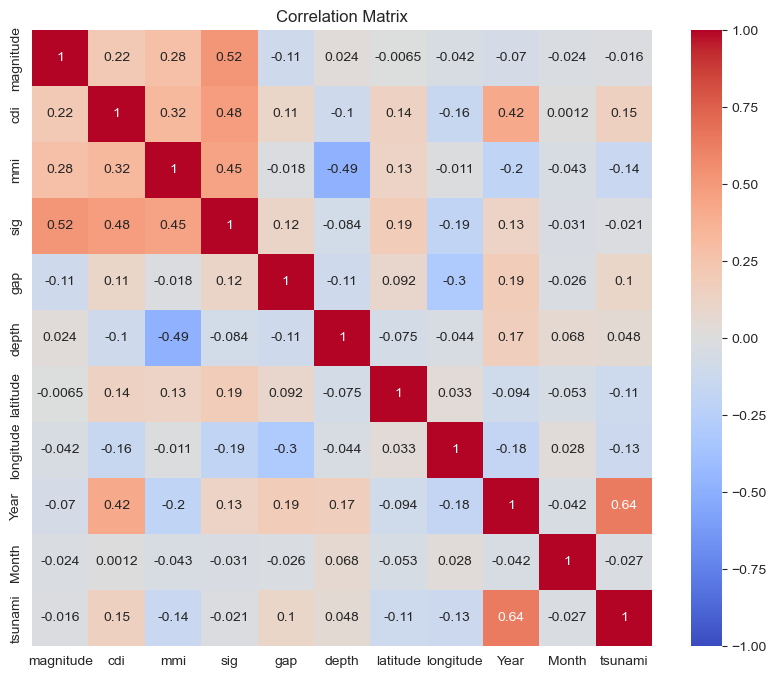

In [8]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1
)
plt.title('Correlation Matrix')
plt.savefig("D:/work_space/data1030_midterm/data1030/midterm_project/figures/correlation_matrix.png")
plt.show()

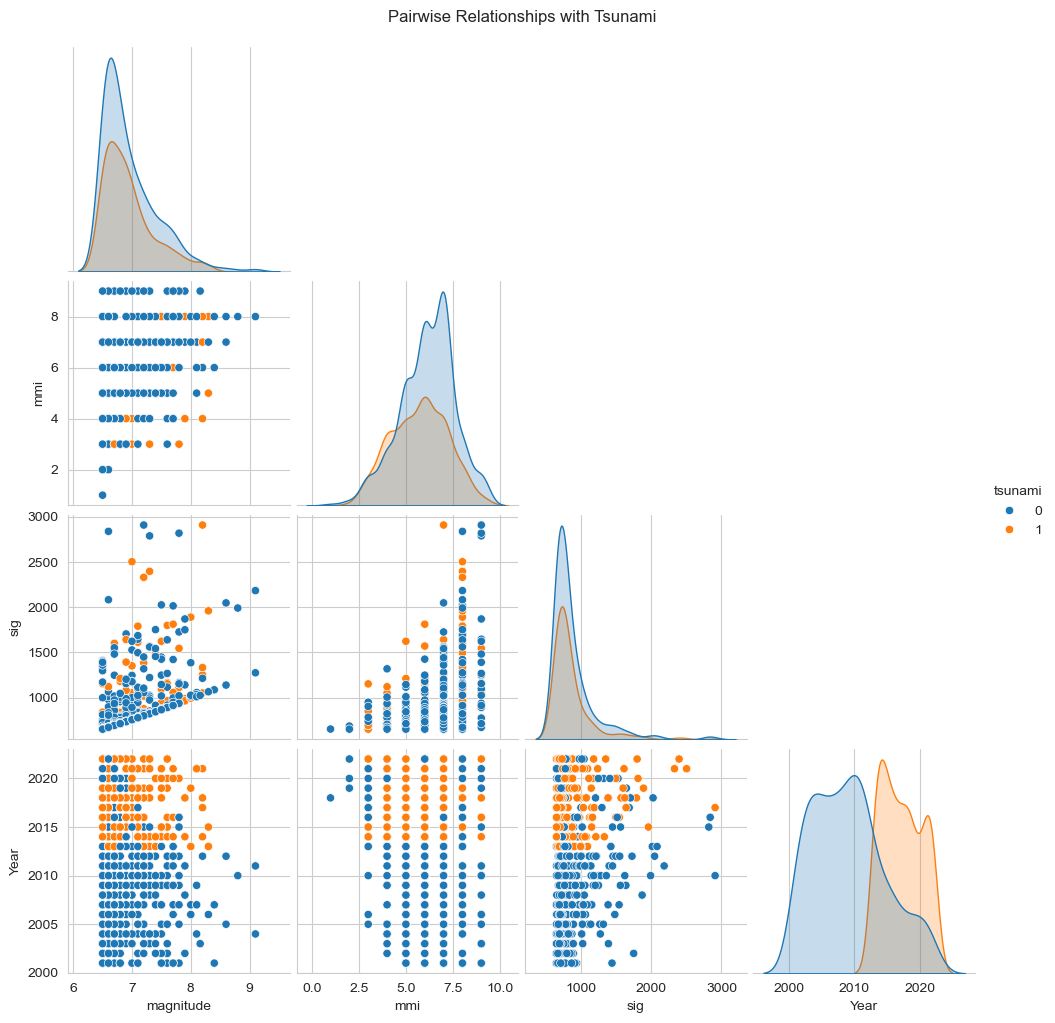

In [9]:
features = ['magnitude', 'mmi', 'sig','Year', 'tsunami']
sns.pairplot(
    df[features],
    hue='tsunami',
    corner=True,
    diag_kind='kde'
)
plt.suptitle('Pairwise Relationships with Tsunami', y=1.02)
plt.savefig("D:/work_space/data1030_midterm/data1030/midterm_project/figures/pairwise_relationships.png")
plt.show()

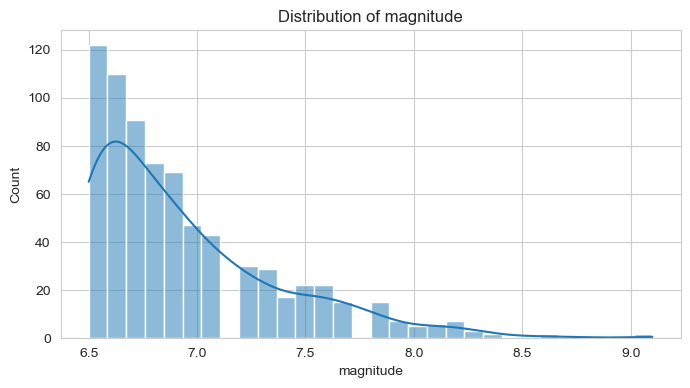

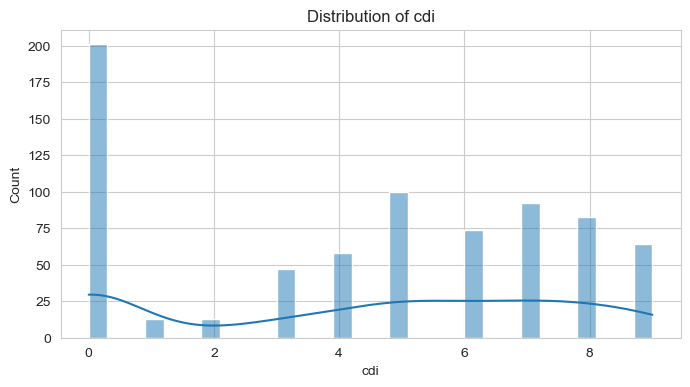

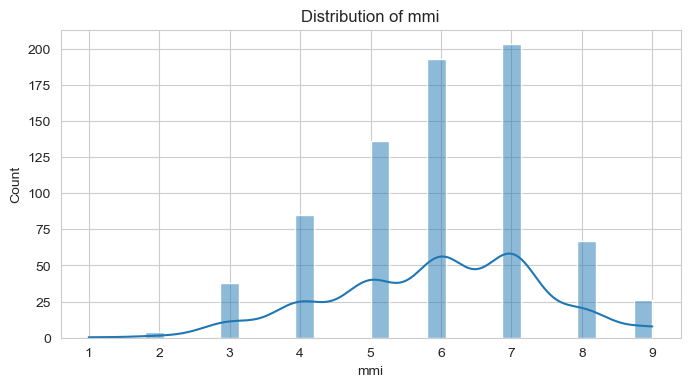

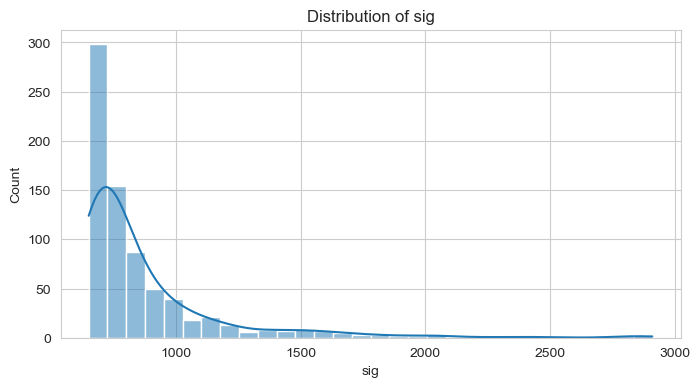

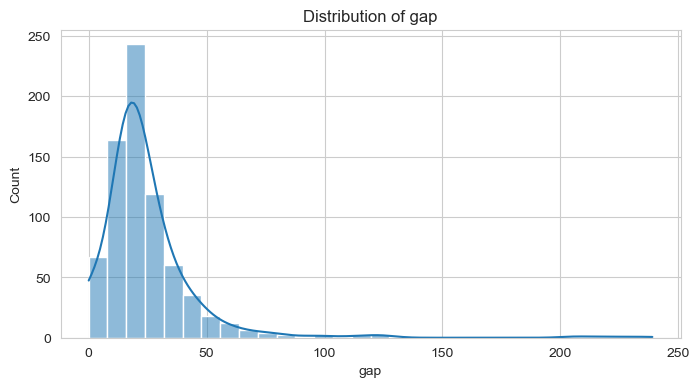

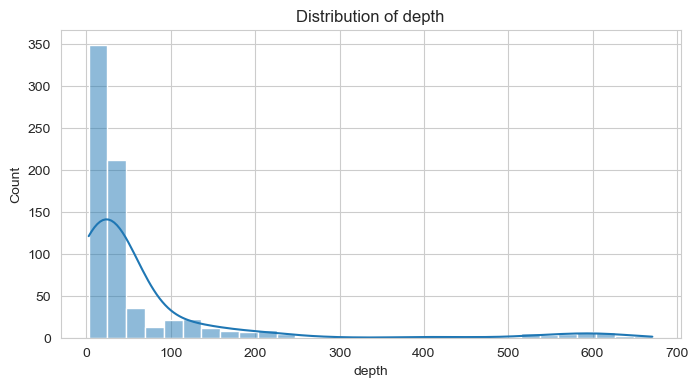

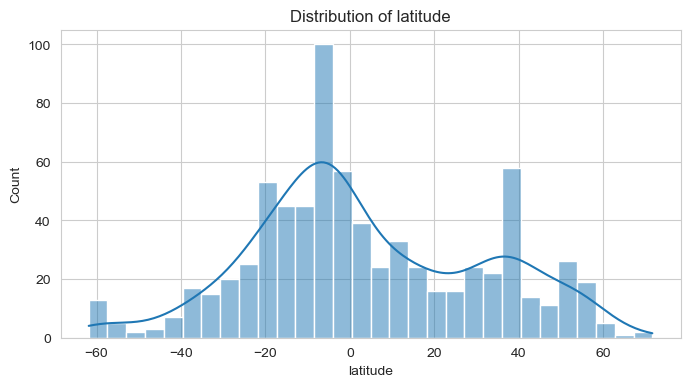

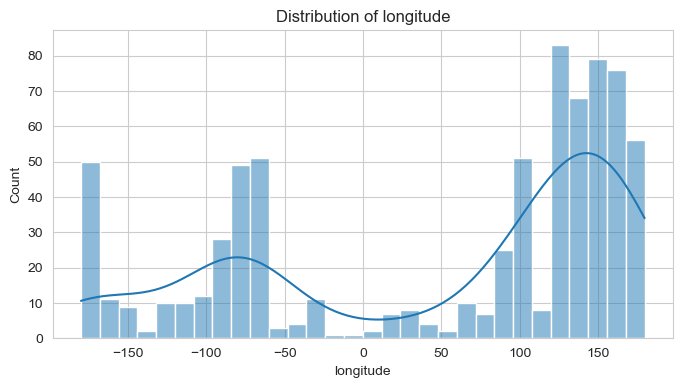

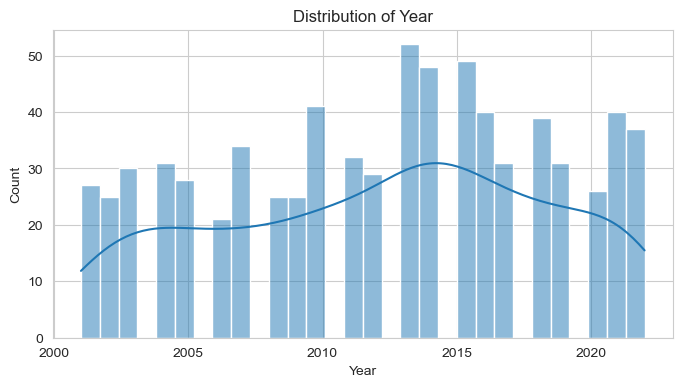

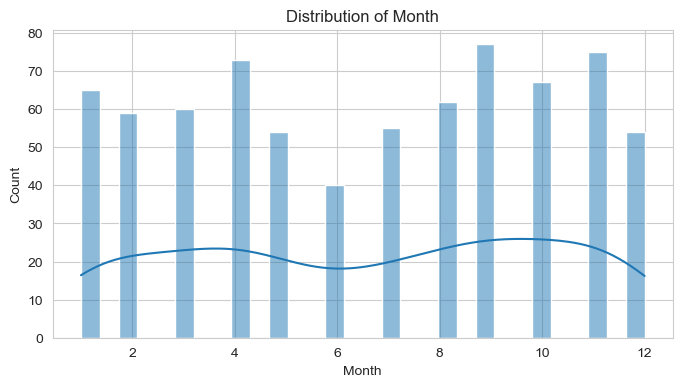

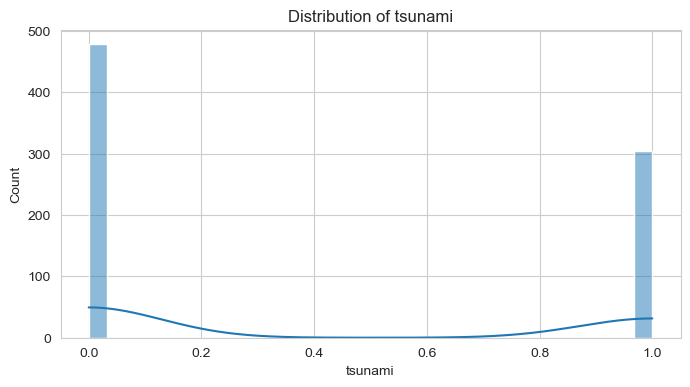

In [10]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=col, kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.savefig(f"D:/work_space/data1030_midterm/data1030/midterm_project/figures/distrib_of_{col}.png")
    plt.show()

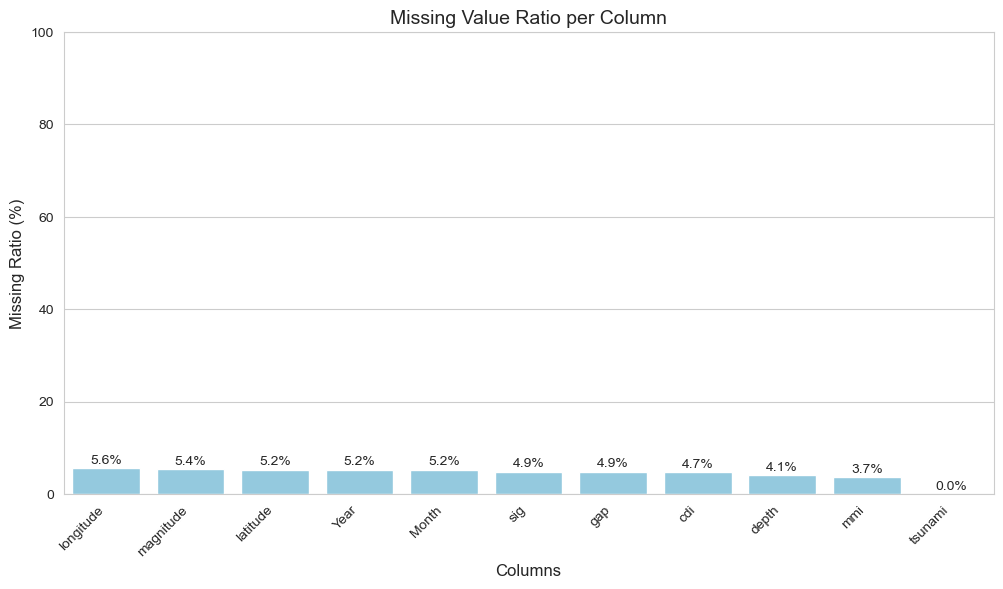

In [11]:
missing_ratio = df.isna().sum() / len(df) * 100
missing_df = pd.DataFrame({'Column': missing_ratio.index, 'Missing Ratio (%)': missing_ratio.values})

missing_df = missing_df.sort_values('Missing Ratio (%)', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=missing_df, x='Column', y='Missing Ratio (%)', color='skyblue')
for i, v in enumerate(missing_df['Missing Ratio (%)']):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)
plt.title('Missing Value Ratio per Column', fontsize=14)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Missing Ratio (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.savefig("D:/work_space/data1030_midterm/data1030/midterm_project/figures/missing_value_ratio.png")
plt.show()

In [12]:
df.isna().sum()

magnitude    42
cdi          37
mmi          29
sig          38
gap          38
depth        32
latitude     41
longitude    44
Year         41
Month        41
tsunami       0
dtype: int64

In [13]:
col_for_mod=["longitude", "magnitude", "latitude", "gap", "sig", "cdi", "depth", "mmi"]
col_for_special=["Year", "Month"]
for col in col_for_mod:
    df[col] = df[col].fillna(df[col].mode()[0])
for col in col_for_special:
    df[col] = df[col].ffill()
df["Year"] = df["Year"].fillna(df["Year"].mode()[0])

In [14]:
df.isna().sum()

magnitude    0
cdi          0
mmi          0
sig          0
gap          0
depth        0
latitude     0
longitude    0
Year         0
Month        0
tsunami      0
dtype: int64

In [15]:
df['Year'] = df['Year'].astype(int)
df['Month'] = df['Month'].astype(int)

In [16]:
numeric_cols = ['magnitude', 'depth', 'cdi', 'mmi', 'sig', 'gap', 'latitude', 'longitude']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [17]:
scaler = MinMaxScaler()
df['Year_scaled'] = scaler.fit_transform(df[['Year']])
df = df.drop('Year', axis=1)

df['Month_scaled'] = scaler.fit_transform(df[['Month']])
df = df.drop('Month', axis=1)

In [18]:
df.head(5)

,magnitude,cdi,mmi,sig,gap,depth,latitude,longitude,tsunami,Year_scaled,Month_scaled
0,0.171533,-1.282619,0.687672,-0.285029,-0.274053,-0.436038,-0.495580,0.960403,1,0.571429,0.909091
1,-0.051511,-0.044337,-1.383289,-0.388994,0.448016,-0.352013,-0.313627,-1.640382,0,1.000000,0.909091
2,0.171533,-0.353908,-2.073609,-0.325985,-0.231579,3.879832,-0.881052,-1.724682,1,1.000000,0.909091
3,0.840664,0.265233,-0.692969,-0.080248,-0.104155,-0.260348,-0.852520,-1.675286,1,1.000000,0.909091
4,-0.720643,-1.282619,-2.763929,-0.593774,0.150693,-0.466593,-1.089453,1.108839,1,1.000000,0.909091


In [19]:
X = df.drop('tsunami', axis=1) 
y = df['tsunami']


X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,  
    stratify=y  
)

In [20]:
baseline_class = y_train_total.value_counts().idxmax()  
baseline_accuracy = y_train_total.value_counts(normalize=True).max()  
y_pred_baseline = np.full_like(y_train_total, baseline_class)
baseline_f1 = f1_score(y_train_total, y_pred_baseline, average='weighted')
baseline_fbeta = fbeta_score(y_train_total, y_pred_baseline, beta=2, average='weighted')

y_score_baseline = np.where(y_pred_baseline == 1, 1, 0)
baseline_auc = roc_auc_score(y_train_total, y_score_baseline)

print(f"The majority: {baseline_class}")
print(f"Baseline accuracy: {baseline_accuracy:.4f}")
print(f"Baseline F1: {baseline_f1:.4f}")
print(f"Baseline F-beta (beta=2): {baseline_fbeta:.4f}")
print(f"Baseline AUC-ROC: {baseline_auc:.4f}")

The majority: 0
Baseline accuracy: 0.6112
Baseline F1: 0.4637
Baseline F-beta (beta=2): 0.5422
Baseline AUC-ROC: 0.5000


In [21]:
models = {
    "Logistic Regression": LogisticRegression(random_state=SEED, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=SEED),
    "Random Forest": RandomForestClassifier(random_state=SEED),
    "XGBoost": XGBClassifier(random_state=SEED)
}

param_grids = {
    "Logistic Regression": {}, 
    "Decision Tree": {}, 
    "Random Forest": {
        "n_estimators": [50, 100, 200, 300]  
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200, 300]  
    }
}

metrics = {
    "accuracy": accuracy_score,
    "f1": lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
    "fbeta": lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=2, average='weighted'),
    "auc": roc_auc_score
}

cv_results = {name: {m: [] for m in metrics.keys()} for name in models.keys()}
n_repeats = 5
all_repeat_results = {name: {m: [] for m in metrics.keys()} for name in models.keys()}

best_params_log = {name: [] for name in models.keys()}

for repeat in range(n_repeats):
    print(f"\n=== Repeat {repeat+1}/{n_repeats} ===")
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED + repeat)
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_total), 1):
        print(f"  Fold {fold}/5")
        X_train, X_val = X_train_total.iloc[train_idx], X_train_total.iloc[val_idx]
        y_train, y_val = y_train_total.iloc[train_idx], y_train_total.iloc[val_idx]
        
        for model_name, model in models.items():
            if param_grids[model_name]:
                grid_search = GridSearchCV(
                    estimator=model,
                    param_grid=param_grids[model_name],
                    cv=3, 
                    scoring='accuracy',  
                    n_jobs=-1,  
                )
                grid_search.fit(X_train, y_train)
                best_model = grid_search.best_estimator_
                best_params_log[model_name].append(grid_search.best_params_)
                print(f"    {model_name} best n_estimators: {grid_search.best_params_['n_estimators']}")
            else:
                best_model = model
                best_model.fit(X_train, y_train)
            
            y_pred = best_model.predict(X_val)
            y_score = best_model.predict_proba(X_val)[:, 1] if hasattr(best_model, "predict_proba") else y_pred
            
            cv_results[model_name]["accuracy"].append(metrics["accuracy"](y_val, y_pred))
            cv_results[model_name]["f1"].append(metrics["f1"](y_val, y_pred))
            cv_results[model_name]["fbeta"].append(metrics["fbeta"](y_val, y_pred))
            cv_results[model_name]["auc"].append(metrics["auc"](y_val, y_score))
    
    for model_name in models.keys():
        for m in metrics.keys():
            all_repeat_results[model_name][m].append(np.mean(cv_results[model_name][m]))

final_results = {}
for model_name in models.keys():
    final_results[model_name] = {}
    for m in metrics.keys():
        split_std = np.std(cv_results[model_name][m])
        non_det_std = np.std(all_repeat_results[model_name][m])
        mean_score = np.mean(all_repeat_results[model_name][m])
        total_std = np.sqrt(split_std**2 + non_det_std**2)  
        
        final_results[model_name][m] = {
            "mean": mean_score,
            "split_std": split_std,
            "non_det_std": non_det_std,
            "total_std": total_std,
            "std_above_baseline": (mean_score - globals()[f"baseline_{m}"]) / total_std if total_std != 0 else np.nan
        }


=== Repeat 1/5 ===
  Fold 1/5
    Random Forest best n_estimators: 200
    XGBoost best n_estimators: 50
  Fold 2/5
    Random Forest best n_estimators: 100
    XGBoost best n_estimators: 50
  Fold 3/5
    Random Forest best n_estimators: 200
    XGBoost best n_estimators: 50
  Fold 4/5
    Random Forest best n_estimators: 200
    XGBoost best n_estimators: 50
  Fold 5/5
    Random Forest best n_estimators: 300
    XGBoost best n_estimators: 50

=== Repeat 2/5 ===
  Fold 1/5
    Random Forest best n_estimators: 100
    XGBoost best n_estimators: 50
  Fold 2/5
    Random Forest best n_estimators: 200
    XGBoost best n_estimators: 50
  Fold 3/5
    Random Forest best n_estimators: 200
    XGBoost best n_estimators: 50
  Fold 4/5
    Random Forest best n_estimators: 200
    XGBoost best n_estimators: 50
  Fold 5/5
    Random Forest best n_estimators: 50
    XGBoost best n_estimators: 50

=== Repeat 3/5 ===
  Fold 1/5
    Random Forest best n_estimators: 200
    XGBoost best n_estimators

In [22]:
model_save_dir = "D:/work_space/data1030_midterm/data1030/midterm_project/figures/results"
os.makedirs(model_save_dir, exist_ok=True)

best_params_summary = {}
for model_name in ["Random Forest", "XGBoost"]:
    if best_params_log[model_name]:
        params_df = pd.DataFrame(best_params_log[model_name])
        best_n_estimators = params_df["n_estimators"].mode()[0]
        best_params_summary[model_name] = {"n_estimators": best_n_estimators}
        print(f"\n{model_name} Best parameters: {best_params_summary[model_name]}")
    else:
        best_params_summary[model_name] = {}

final_models = {
    "Logistic Regression": LogisticRegression(random_state=SEED, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=SEED),
    "Random Forest": RandomForestClassifier(
        random_state=SEED,
        **best_params_summary["Random Forest"] 
    ),
    "XGBoost": XGBClassifier(
        random_state=SEED,
        **best_params_summary["XGBoost"]  
    )
}

trained_final_models = {}
for model_name, model in final_models.items():
    print(f"\ntraining and saving {model_name}...")
    model.fit(X_train_total, y_train_total)
    trained_final_models[model_name] = model
    
    model_save_path = os.path.join(model_save_dir, f"{model_name.replace(' ', '_')}.pkl")
    
    joblib.dump(model, model_save_path)
    print(f"{model_name} already saved at: {model_save_path}")


Random Forest Best parameters: {'n_estimators': np.int64(200)}

XGBoost Best parameters: {'n_estimators': np.int64(50)}

training and saving Logistic Regression...
Logistic Regression already saved at: D:/work_space/data1030_midterm/data1030/midterm_project/figures/results\Logistic_Regression.pkl

training and saving Decision Tree...
Decision Tree already saved at: D:/work_space/data1030_midterm/data1030/midterm_project/figures/results\Decision_Tree.pkl

training and saving Random Forest...
Random Forest already saved at: D:/work_space/data1030_midterm/data1030/midterm_project/figures/results\Random_Forest.pkl

training and saving XGBoost...
XGBoost already saved at: D:/work_space/data1030_midterm/data1030/midterm_project/figures/results\XGBoost.pkl


In [23]:
for model_name, res in final_results.items():
    print(f"\n{model_name}:")
    for m in metrics.keys():
        mean = res[m]["mean"]
        std = res[m]["total_std"]
        std_above = res[m]["std_above_baseline"]
        baseline_val = globals()[f"baseline_{m}"]
        print(f"  {m}: {mean:.4f} ± {std:.4f} (baseline {baseline_val:.4f}, {std_above:.2f} standard deviations above baseline)")


Logistic Regression:
  accuracy: 0.8080 ± 0.0298 (baseline 0.6112, 6.61 standard deviations above baseline)
  f1: 0.8068 ± 0.0315 (baseline 0.4637, 10.88 standard deviations above baseline)
  fbeta: 0.8070 ± 0.0308 (baseline 0.5422, 8.61 standard deviations above baseline)
  auc: 0.8920 ± 0.0212 (baseline 0.5000, 18.48 standard deviations above baseline)

Decision Tree:
  accuracy: 0.8791 ± 0.0246 (baseline 0.6112, 10.90 standard deviations above baseline)
  f1: 0.8788 ± 0.0247 (baseline 0.4637, 16.78 standard deviations above baseline)
  fbeta: 0.8787 ± 0.0248 (baseline 0.5422, 13.57 standard deviations above baseline)
  auc: 0.8708 ± 0.0259 (baseline 0.5000, 14.31 standard deviations above baseline)

Random Forest:
  accuracy: 0.9073 ± 0.0194 (baseline 0.6112, 15.23 standard deviations above baseline)
  f1: 0.9082 ± 0.0192 (baseline 0.4637, 23.20 standard deviations above baseline)
  fbeta: 0.9068 ± 0.0197 (baseline 0.5422, 18.52 standard deviations above baseline)
  auc: 0.9594 ± 0

In [24]:
table_data = []
columns = ["Model", "Accuracy (mean±std)", "F1 (mean±std)", "F-beta (mean±std)", "AUC (mean±std)", "Std above baseline (Accuracy)"]
for model_name, res in final_results.items():
    row = [
        model_name,
        f"{res['accuracy']['mean']:.4f} ± {res['accuracy']['total_std']:.4f}",
        f"{res['f1']['mean']:.4f} ± {res['f1']['total_std']:.4f}",
        f"{res['fbeta']['mean']:.4f} ± {res['fbeta']['total_std']:.4f}",
        f"{res['auc']['mean']:.4f} ± {res['auc']['total_std']:.4f}",
        f"{res['accuracy']['std_above_baseline']:.2f}"
    ]
    table_data.append(row)

results_df = pd.DataFrame(table_data, columns=columns)
print(results_df)

                 Model Accuracy (mean±std)    F1 (mean±std) F-beta (mean±std)  \
0  Logistic Regression     0.8080 ± 0.0298  0.8068 ± 0.0315   0.8070 ± 0.0308   
1        Decision Tree     0.8791 ± 0.0246  0.8788 ± 0.0247   0.8787 ± 0.0248   
2        Random Forest     0.9073 ± 0.0194  0.9082 ± 0.0192   0.9068 ± 0.0197   
3              XGBoost     0.9007 ± 0.0212  0.9012 ± 0.0213   0.9004 ± 0.0215   

    AUC (mean±std) Std above baseline (Accuracy)  
0  0.8920 ± 0.0212                          6.61  
1  0.8708 ± 0.0259                         10.90  
2  0.9594 ± 0.0135                         15.23  
3  0.9620 ± 0.0134                         13.62  


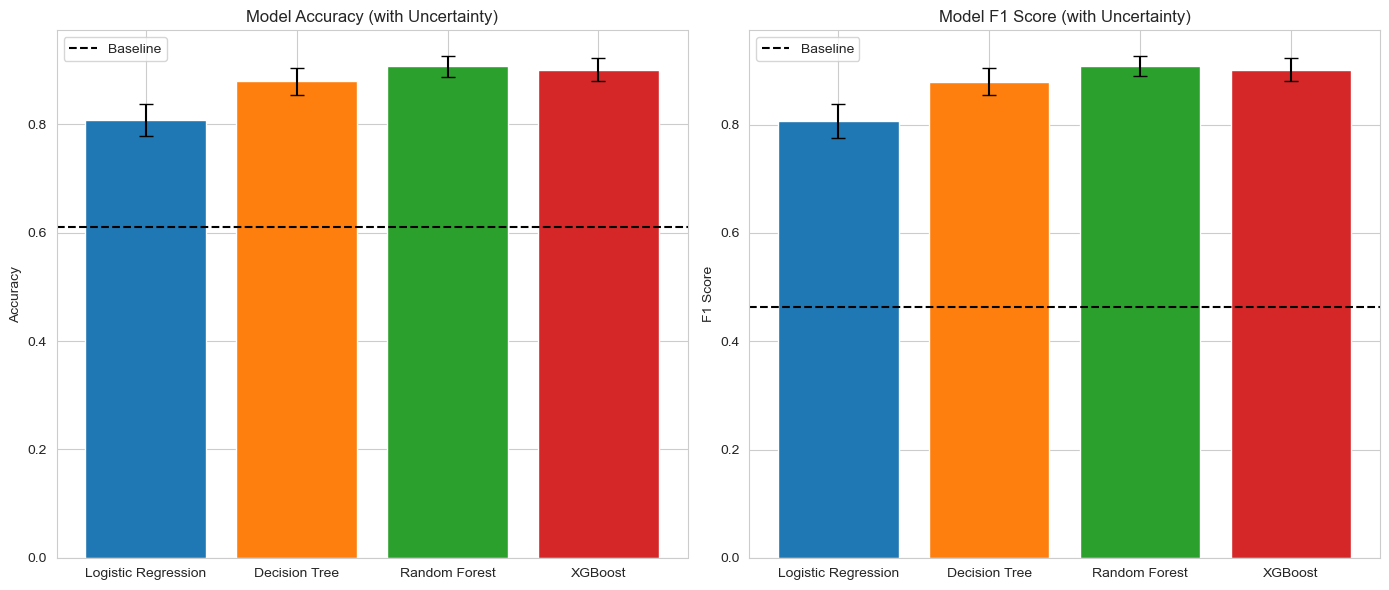

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

model_names = list(final_results.keys())
acc_means = [final_results[m]["accuracy"]["mean"] for m in model_names]
acc_stds = [final_results[m]["accuracy"]["total_std"] for m in model_names]
f1_means = [final_results[m]["f1"]["mean"] for m in model_names]
f1_stds = [final_results[m]["f1"]["total_std"] for m in model_names]

ax1.bar(model_names, acc_means, yerr=acc_stds, capsize=5, color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
ax1.axhline(y=baseline_accuracy, color="black", linestyle="--", label="Baseline")
ax1.set_title("Model Accuracy (with Uncertainty)")
ax1.set_ylabel("Accuracy")
ax1.legend()

ax2.bar(model_names, f1_means, yerr=f1_stds, capsize=5, color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
ax2.axhline(y=baseline_f1, color="black", linestyle="--", label="Baseline")
ax2.set_title("Model F1 Score (with Uncertainty)")
ax2.set_ylabel("F1 Score")
ax2.legend()

plt.tight_layout()
plt.savefig("D:/work_space/data1030_midterm/data1030/midterm_project/figures/model_performance.png")
plt.show()

=== Calculating Model-Builtin Feature Importance ===
Logistic Regression top 3 features (builtin): ['Year_scaled', 'sig', 'magnitude']
Decision Tree top 3 features (builtin): ['Year_scaled', 'longitude', 'latitude']
Random Forest top 3 features (builtin): ['Year_scaled', 'longitude', 'latitude']
XGBoost top 3 features (builtin): ['Year_scaled', 'longitude', 'latitude']

=== Calculating Permutation Feature Importance ===
Logistic Regression top 3 features (permutation): ['Year_scaled', 'magnitude', 'sig']
Decision Tree top 3 features (permutation): ['Year_scaled', 'longitude', 'latitude']
Random Forest top 3 features (permutation): ['Year_scaled', 'longitude', 'latitude']
XGBoost top 3 features (permutation): ['Year_scaled', 'longitude', 'latitude']

=== Calculating SHAP Feature Importance ===
Logistic Regression top 3 features (SHAP): ['Year_scaled', 'magnitude', 'sig']
Decision Tree top 3 features (SHAP): ['latitude', 'longitude', 'gap']
Random Forest top 3 features (SHAP): ['latitude

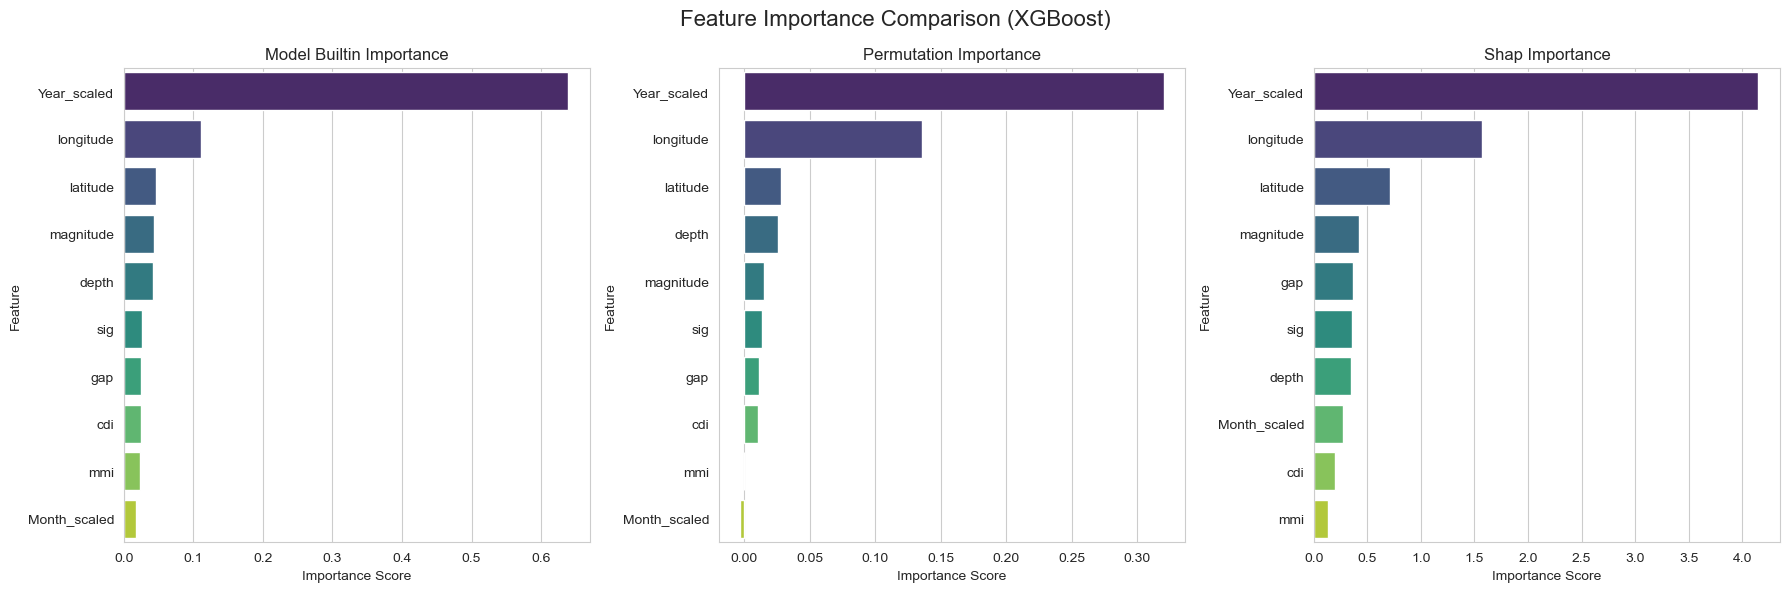


=== Feature Importance Summary (Top 5 Features for XGBoost) ===
                        Feature                           Importance_Score  \
Importance_Method Model Builtin  Permutation         Shap    Model Builtin   
Rank                                                                         
1                   Year_scaled  Year_scaled  Year_scaled           0.6384   
2                     longitude    longitude    longitude           0.1109   
3                      latitude     latitude     latitude           0.0470   
4                     magnitude        depth    magnitude           0.0432   
5                         depth    magnitude          gap           0.0421   

                                       
Importance_Method Permutation    Shap  
Rank                                   
1                      0.3204  4.1452  
2                      0.1357  1.5664  
3                      0.0280  0.7126  
4                      0.0261  0.4183  
5                      0.0153 

<Figure size 1200x400 with 0 Axes>

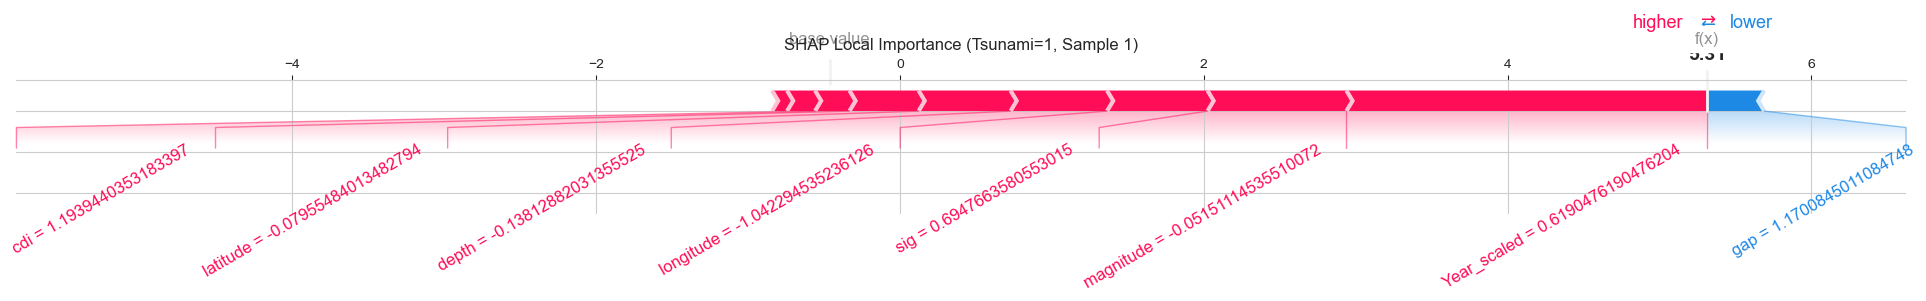

<Figure size 1200x400 with 0 Axes>

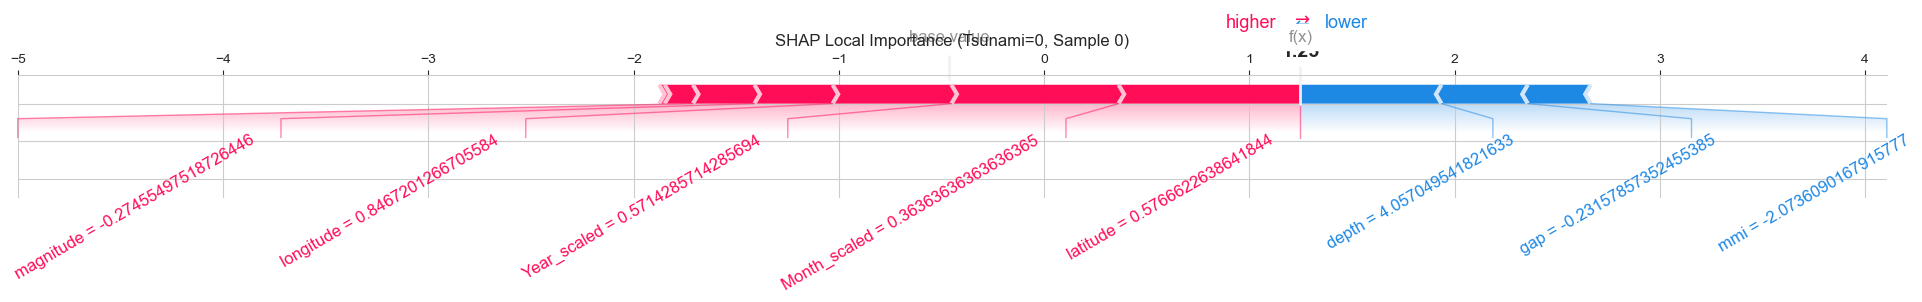

In [26]:

feature_names = X_train_total.columns.tolist()
n_features = len(feature_names)
feature_importance = {
    "model_builtin": {},
    "permutation": {},
    "shap": {}
}

trained_models = {}
for model_name, model in models.items():
    model.fit(X_train_total, y_train_total)
    trained_models[model_name] = model

print("=== Calculating Model-Builtin Feature Importance ===")
for model_name, model in trained_models.items():
    if hasattr(model, "feature_importances_"):
        builtin_imp = pd.Series(model.feature_importances_, index=feature_names)
    elif isinstance(model, LogisticRegression):
        builtin_imp = pd.Series(np.abs(model.coef_[0]), index=feature_names)
    else:
        builtin_imp = pd.Series(np.zeros(n_features), index=feature_names)
        print(f"Warning: {model_name} has no built-in feature importance")
    
    feature_importance["model_builtin"][model_name] = builtin_imp.sort_values(ascending=False)
    print(f"{model_name} top 3 features (builtin): {builtin_imp.nlargest(3).index.tolist()}")

print("\n=== Calculating Permutation Feature Importance ===")
perm_kwargs = {
    "X": X_test_total,
    "y": y_test_total,
    "n_repeats": 10,
    "random_state": SEED,
    "scoring": "accuracy"
}

for model_name, model in trained_models.items():
    perm_imp = permutation_importance(model, **perm_kwargs)
    perm_imp_series = pd.Series(perm_imp.importances_mean, index=feature_names)
    feature_importance["permutation"][model_name] = perm_imp_series.sort_values(ascending=False)
    print(f"{model_name} top 3 features (permutation): {perm_imp_series.nlargest(3).index.tolist()}")

print("\n=== Calculating SHAP Feature Importance ===")
for model_name, model in trained_models.items():
    try:
        if isinstance(model, LogisticRegression):
            masker = shap.maskers.Independent(X_train_total)
            explainer = shap.LinearExplainer(model, masker=masker)
            shap_vals = explainer.shap_values(X_test_total)
            if shap_vals.ndim == 3:
                shap_vals = shap_vals[:, :, 1]
            elif shap_vals.ndim == 2:
                if shap_vals.shape[1] == 2:
                    shap_vals = X_test_total.values * shap_vals[:, 1][:, np.newaxis]
                elif shap_vals.shape[1] == n_features:
                    pass
                else:
                    shap_vals = shap_vals[:, :n_features]
        elif hasattr(model, "tree_") or "XGB" in model_name:
            explainer = shap.TreeExplainer(model)
            shap_vals = explainer.shap_values(X_test_total)
            if isinstance(shap_vals, list):
                shap_vals = shap_vals[1]
            if shap_vals.ndim == 2 and shap_vals.shape[1] != n_features:
                shap_vals = shap_vals[:, :n_features]
        
        shap_vals = shap_vals.reshape(-1, n_features)
        shap_imp_vals = np.abs(shap_vals).mean(axis=0)
        shap_imp_series = pd.Series(shap_imp_vals, index=feature_names)
        feature_importance["shap"][model_name] = shap_imp_series.sort_values(ascending=False)
        print(f"{model_name} top 3 features (SHAP): {shap_imp_series.nlargest(3).index.tolist()}")
    
    except Exception as e:
        print(f"Error calculating SHAP for {model_name}: {str(e)} (skipping)")
        continue

plt.rcParams['figure.figsize'] = (18, 12)
sns.set_style("whitegrid")

target_model = "XGBoost"
importance_types = ["model_builtin", "permutation", "shap"]

if target_model in feature_importance["shap"]:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Feature Importance Comparison ({target_model})", fontsize=16)

    for idx, imp_type in enumerate(importance_types):
        imp_series = feature_importance[imp_type][target_model]
        sns.barplot(
            x=imp_series.head(10).values,
            y=imp_series.head(10).index,
            hue=imp_series.head(10).index,
            ax=axes[idx],
            palette="viridis",
            legend=False
        )
        axes[idx].set_title(f"{imp_type.replace('_', ' ').title()} Importance")
        axes[idx].set_xlabel("Importance Score")
        axes[idx].set_ylabel("Feature")

    plt.tight_layout()
    plt.savefig(f"D:/work_space/data1030_midterm/data1030/midterm_project/figures/{target_model}_feature_importance_3_methods.png", bbox_inches="tight")
    plt.show()

summary_data = []
if target_model in feature_importance["shap"]:
    for imp_type in importance_types:
        imp_series = feature_importance[imp_type][target_model]
        top_5 = imp_series.head(5)
        for rank, (feature, score) in enumerate(top_5.items(), 1):
            summary_data.append({
                "Importance_Method": imp_type.replace('_', ' ').title(),
                "Rank": rank,
                "Feature": feature,
                "Importance_Score": round(score, 4)
            })

    summary_df = pd.DataFrame(summary_data)
    print("\n=== Feature Importance Summary (Top 5 Features for XGBoost) ===")
    print(summary_df.pivot_table(
        index="Rank",
        columns="Importance_Method",
        values=["Feature", "Importance_Score"],
        aggfunc="first"
    ))

    agg_imp = pd.DataFrame()
    for imp_type in importance_types:
        agg_imp[imp_type] = feature_importance[imp_type][target_model]

    agg_imp["Mean_Importance"] = agg_imp.mean(axis=1)
    agg_imp = agg_imp.sort_values("Mean_Importance", ascending=False)

    print("\n=== Most/Least Important Features (Aggregated) ===")
    print(f"Most important feature: {agg_imp.index[0]} (Mean Score: {agg_imp['Mean_Importance'].iloc[0]:.4f})")
    print(f"2nd most important feature: {agg_imp.index[1]} (Mean Score: {agg_imp['Mean_Importance'].iloc[1]:.4f})")
    print(f"Least important feature: {agg_imp.index[-1]} (Mean Score: {agg_imp['Mean_Importance'].iloc[-1]:.4f})")
    print(f"2nd least important feature: {agg_imp.index[-2]} (Mean Score: {agg_imp['Mean_Importance'].iloc[-2]:.4f})")

print("\n=== Generating SHAP Local Feature Importance Plots ===")
if target_model in trained_models:
    model = trained_models[target_model]
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(X_test_total)
    
    if isinstance(shap_vals, list):
        shap_vals = shap_vals[1]
    shap_vals = shap_vals.reshape(-1, n_features)

    positive_idx = np.where(y_test_total == 1)[0][0] if 1 in y_test_total.values else 0
    negative_idx = np.where(y_test_total == 0)[0][0] if 0 in y_test_total.values else 1

    plt.figure(figsize=(12, 4))
    shap.force_plot(
        explainer.expected_value,
        shap_vals[positive_idx],
        features=X_test_total.iloc[positive_idx],
        feature_names=feature_names,
        matplotlib=True,
        show=False,
        text_rotation=30
    )
    plt.title(f"SHAP Local Importance (Tsunami=1, Sample {positive_idx})")
    plt.tight_layout()
    plt.savefig("D:/work_space/data1030_midterm/data1030/midterm_project/figures/shap_local_positive.png")
    plt.show()

    plt.figure(figsize=(12, 4))
    shap.force_plot(
        explainer.expected_value,
        shap_vals[negative_idx],
        features=X_test_total.iloc[negative_idx],
        feature_names=feature_names,
        matplotlib=True,
        show=False,
        text_rotation=30
    )
    plt.title(f"SHAP Local Importance (Tsunami=0, Sample {negative_idx})")
    plt.tight_layout()
    plt.savefig("D:/work_space/data1030_midterm/data1030/midterm_project/figures/shap_local_negative.png")
    plt.show()